# Evolutionary Machi Koro: Analysis

To start, let's create a set of organisms with random chromosomes.

In [1]:
from embark.evolution import Organism, make_random_chromosome
from embark.parameters import GENERATION_SIZE

generation = {Organism(make_random_chromosome()) for _ in range(GENERATION_SIZE)}

Next, we'll simulate 100 rounds of evolution.

In [2]:
from embark.evolution import iterate

generations = []
for index in range(100):
    generation = set(iterate(generation))
    generations.append(generation)

## Elo Rating System

Elo is a rating system that describes a player's skill relative to the rest of the field.

Let's define some functions to calculate Elo ratings.

In [3]:
K_FACTOR = 32
STARTING_RATING = 1200

def find_expected_score(rating, opponent_rating):
    """Calculate the win probability for a pairing."""
    return 1 / (1 + 10**((opponent_rating - rating) / 400))

def update_elo(rating, opponent_rating, won):
    """Determine the new rating a player gets from a single result."""
    score = 1 if won else 0
    return rating + K_FACTOR * (score - find_expected_score(rating, opponent_rating))

The world's best chess player, Magnus Carlsen,  has an Elo rating of 2843. The average club player is about 1500. What's the probability that the club player beats Carlsen?

In [4]:
find_expected_score(1500, 2843)

0.00043884319773774524

Oof. Not looking good for the club player. If (when) Magnus wins, his rating only slightly improves.

In [5]:
update_elo(2843, 1500, True)

2843.0140429823277

The opposite result has a much larger point swing.

In [6]:
update_elo(1500, 2843, True)

1531.9859570176725

## Machi Koro Elo

Now, let's apply the Elo rating system to our Machi Koro algorithm. This will help us determine how much the strength of the computer player increases.

First, let's find the winning organism of each generation of evolution.

In [7]:
winners = [max(generation, key=lambda organism: organism.wins) for generation in generations]

Next, let's set the default rating on every organism.

In [15]:
for winner in winners:
    winner.rating = STARTING_RATING

Finally, let's simulate a large number of games. After each game, we'll update the player's Elo ratings.

In [ ]:
from itertools import combinations
from embark.machi_koro import Game

for _ in range(10):
    for player1, player2 in combinations(reversed(winners), 2):
        game = Game(player1, player2)
        game.simulate()
        player1.rating = update_elo(player1.rating, player2.rating, game.winner == player1)
        player2.rating = update_elo(player2.rating, player1.rating, game.winner == player2)

Here's a graph of our Elo scores per round:

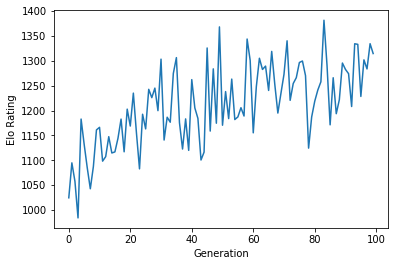

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([winner.rating for winner in winners])
plt.ylabel('Elo Rating')
plt.xlabel('Generation')
plt.show()

Looking good! The ratings mostly increase as the genetic algorithm improves the fitness of the population.

What's the probability that the winner of the hundredth generation beats the winner of the first generation?

In [20]:
find_expected_score(winners[-1].rating, winners[0].rating)

0.8416661585679521

This means that the 100th winner should win about 84% of games against the 1st winner.

All Elo ratings are on the low end. Even the good strategies seem to lose frequently. Machi Koro's random element (dice rolls) likely contribute here.

## Best and Worst Cards

Which card did the genetic algorithm find most useful? How soon did EMbArK discover this card?

Let's visualize card probabilities over time. We'll plot one line per card. Each point will be the average gene probability for one generation.

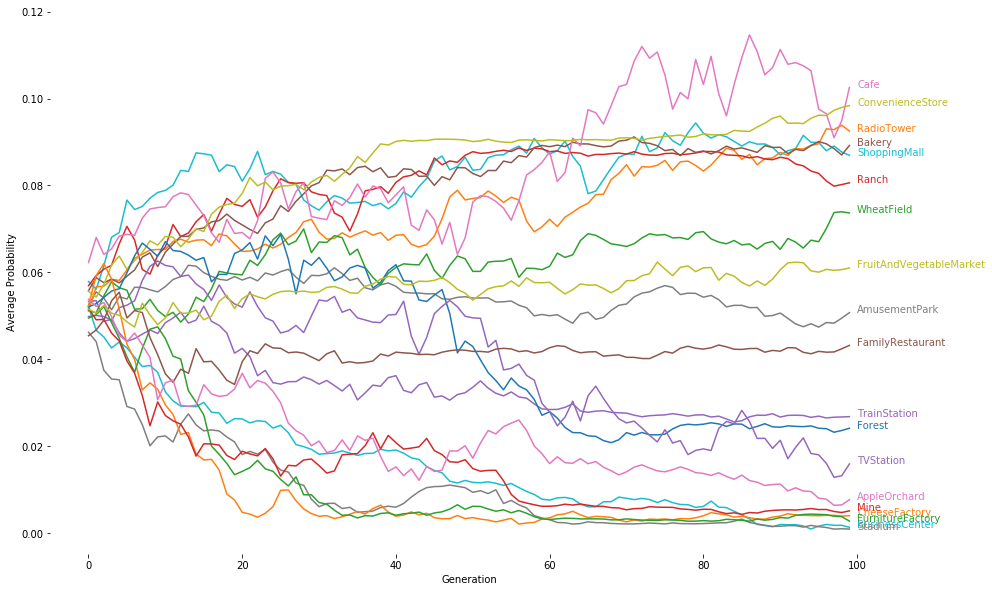

In [12]:
from itertools import cycle
from embark.machi_koro import ALL_CARDS

COLORS = cycle(["#9467bd", "#17becf", "#7f7f7f", "#ff7f0e", "#2ca02c", "#d62728", "#8c564b",
                "#e377c2", "#bcbd22", "#1f77b4"])

plt.figure(figsize=(15, 10))

# Remove chart border.
ax = plt.subplot()
for border in ["top", "bottom", "right", "left"]:
    ax.spines[border].set_visible(False)

for card, color in zip(ALL_CARDS, cycle(COLORS)):
    line = [sum(organism[card] for organism in generation) / len(generation)
            for generation in generations]
    plt.plot(line, color=color)
    plt.text(len(generations), line[-1], card.__name__, color=color)
    
plt.ylabel('Average Probability')
plt.xlabel('Generation')
plt.show()

At the end of the genetic algorithm the five cheapest cards are in the top seven most useful genes. EMbArK's strategy seems to embody frequent purchases of low-cost cards. Organisms do not save money. The algorithm buys cheap cards to create a snowball effect; income increases exponentially.

The algorithm also favors the *Wheat Field* and the *Fruit and Vegetable Market*. These cards combo; the amount of reward from the Fruit and Vegetable Market depends on the number of Wheat Fields the player owns. EMbArK cleverly places a similar high probability on these two cards.

The Cafe seems to be the best card in the game. EMbArK makes a great choice here. It's cheap (two coins) and steals money from the opponent.

All four *landmark* cards are required to win the game. These are the *Train Station*, *Amusement Park*, *Shopping Mall*, and *RadioTower*. The algorithm places a surprisingly low weight on the Train Station. This card makes the player roll two dice instead of one. At first glance these seems like a mistake. Why wouldn't EMbArK place a high probability on a winning card?

Closer examination reveals brilliance. As mentioned above, EMbArK gives high probability to cheap cards. These cheap cards generally have low activation numbers (1, 2, 2-3, 3, and 4). The activation number defines which dice roll gives a reward. The top chromosomes intelligently delay purchasing the Train Station in order to keep dice rolls low.